In [1]:
import sys
import os
sys.path.append(os.path.join(os.getcwd(), ".."))
from collections import defaultdict

import numpy as np
import pandas as pd
from tqdm import tqdm
import postprocess_general_loader
import postprocess_randomness_loader
import postprocess_randomness_enhanced_loader
import src_py.feature
import matplotlib.pyplot as plt
import statistics
import randomness_analysis_loader
import math
import postprocess_selfdraw_loader
import copy
import random
from operator import add
def default_value():
    return 0
def default_list():
    return []
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams["figure.figsize"] = (15,7)
plt.rcParams['font.size'] = (16)

In [2]:
def pure_simulation(length_of_game, sim_count):
    a = [[[0,0,0,0]] for _ in range(sim_count)]
    for i in range(length_of_game):
        for j in range(sim_count):
            win_idx = random.randint(0,4)
            # construct one hot winner
            oh=[]
            for w in range(4):
                if win_idx==w:
                    oh.append(1)
                else:
                    oh.append(0)
            a[j].append(oh)
    # a: 1000 * length_of_game+1 * 4]
    # make list a become cumulative
    for i in range(sim_count):
        for j in range(1,length_of_game+1):
            prev = a[i][j-1]
            cur = a[i][j]
            a[i][j]=list(map(add, prev, cur))
    avg_max_diff = []
    # std_max_diff = []
    max_diff_95 = []
    for j in range(10,length_of_game+1):
        max_diff = []
        min_diff = []
        avg_diff = []
        for i in range (sim_count):
            res = a[i][j]
            res.sort()
            min_dif = 1000
            for i in range(1,4):
                dif = abs(res[i]-res[i-1])
                if dif<min_dif:
                    min_dif = dif
            max_dif = 1.0*(max(res)-min(res))/sum(res)*100
            max_diff.append(max_dif)
        avg_max_diff.append(1.0*sum(max_diff)/len(max_diff))
        max_diff.sort()
        max_diff_95.append(max_diff[-int(sim_count*0.05)])
        # std_max_diff.append(statistics.stdev(max_diff))
    return avg_max_diff, max_diff_95

In [3]:
def graph_raw_win_rate(file_path, file_name, title, theoretical_max_diff_95 = None, theoretical_avg_max_diff = None):
    win_rate_list, score_list,  length_of_valid_entry, total_list_length = randomness_analysis_loader.load_from_result(file_path, file_name)
    print("{:d} out of {:d} rounds filtered in, discarding {:.2f} % games".format(length_of_valid_entry, total_list_length,  (1-1.0*length_of_valid_entry/total_list_length)*100))
    win_rate = []
    win_rate_95 = []
    win_rate_stdev = []
    length_of_plot = 2000
    epsilon = 1e-5
    for i in range(10,length_of_plot):
        tmp_list=[]
        diff = 0
        for j in range(len(win_rate_list)):
            tmp = (max(win_rate_list[j][i]) - min(win_rate_list[j][i])+epsilon)/sum(win_rate_list[j][i], epsilon)*100
            tmp_list.append(tmp)
            diff += tmp
        tmp_list.sort()
        win_rate_95.append(tmp_list[int(len(win_rate_list)*0.95)])
        win_rate.append(diff/len(win_rate_list))
        win_rate_stdev.append(statistics.stdev(tmp_list))
    lower_bound = [2*(3/(16*i))**0.5/(math.sqrt(math.pi)) /1*100 for i in range(10,length_of_plot)]
    x_axis = list(range(10,length_of_plot))
    plt.rcParams["figure.figsize"] = (20,8)
    plt.rcParams['font.sans-serif']=['SimHei']
    # plt.scatter(x_axis,win_rate_diff_strict3, label = "Avg Win-rate Diff")
    plt.plot(x_axis, win_rate, label = "Avg Win-rate Diff")
    plt.plot(x_axis, win_rate_95, label = "95% Win-rate Diff")
    plt.plot(x_axis, win_rate_stdev, label = "Win-rate Diff STDEV")
    if not theoretical_max_diff_95==None:
        plt.plot(x_axis, theoretical_max_diff_95[:-1], label = "Simulation 95%")
    if not theoretical_avg_max_diff==None:
        plt.plot(x_axis, theoretical_avg_max_diff[:-1], label = "simulation average max diff")
    plt.plot(x_axis, lower_bound, label = "Win-rate Diff Lower-bound")
    # plt.suptitle('Round-count vs Win-Rate Diff')
    plt.legend()
    plt.title(title)   # 柱状图标题
    plt.show()

In [4]:
def graph_raw_win_rate_short(file_path, file_name, title, theoretical_max_diff_95 = None, theoretical_avg_max_diff = None):
    win_rate_list, score_list,  length_of_valid_entry, total_list_length = randomness_analysis_loader.load_from_result(file_path, file_name)
    print("{:d} out of {:d} rounds filtered in, discarding {:.2f} % games".format(length_of_valid_entry, total_list_length,  (1-1.0*length_of_valid_entry/total_list_length)*100))
    win_rate = []
    win_rate_95 = []
    win_rate_stdev = []
    length_of_plot = 300
    epsilon = 1e-5
    for i in range(10,length_of_plot):
        tmp_list=[]
        diff = 0
        for j in range(len(win_rate_list)):
            tmp = (max(win_rate_list[j][i]) - min(win_rate_list[j][i])+epsilon)/sum(win_rate_list[j][i], epsilon)*100
            tmp_list.append(tmp)
            diff += tmp
        tmp_list.sort()
        win_rate_95.append(tmp_list[int(len(win_rate_list)*0.95)])
        win_rate.append(diff/len(win_rate_list))
        win_rate_stdev.append(statistics.stdev(tmp_list))
    lower_bound = [2*(3/(16*i))**0.5/(math.sqrt(math.pi)) /1*100 for i in range(10,length_of_plot)]
    x_axis = list(range(10,length_of_plot))
    plt.rcParams["figure.figsize"] = (20,8)
    plt.rcParams['font.sans-serif']=['SimHei']
    # plt.scatter(x_axis,win_rate_diff_strict3, label = "Avg Win-rate Diff")
    plt.plot(x_axis, win_rate, label = "Avg Win-rate Diff")
    plt.plot(x_axis, win_rate_95, label = "95% Win-rate Diff")
    plt.plot(x_axis, win_rate_stdev, label = "Win-rate Diff STDEV")
    if not theoretical_max_diff_95==None:
        plt.plot(x_axis, theoretical_max_diff_95[:length_of_plot-10], label = "Simulation 95%")
    if not theoretical_avg_max_diff==None:
        plt.plot(x_axis, theoretical_avg_max_diff[:length_of_plot-10], label = "simulation average max diff")
    plt.plot(x_axis, lower_bound, label = "Win-rate Diff Lower-bound")
    # plt.suptitle('Round-count vs Win-Rate Diff')
    plt.legend()
    plt.title(title)   # 柱状图标题
    plt.show()
    return win_rate

In [5]:
def graph_win_rate_distri(file_path, file_name, title):
    """
    At game length = 1500, graph the distribution of (max wr - min wr)
    """
    win_rate_list, score_list,  length_of_valid_entry, total_list_length = randomness_analysis_loader.load_from_result(file_path, file_name)
    win_rate_diff = defaultdict(default_value)
    game_length = 1500
    for j in range(len(win_rate_list)):
        tmp = (max(win_rate_list[j][game_length]) - min(win_rate_list[j][game_length]))/sum(win_rate_list[j][game_length])*100
        win_rate_diff[tmp]+=1
    plt.rcParams["figure.figsize"] = (20,8)
    plt.rcParams['font.sans-serif']=['SimHei']
    # plt.scatter(x_axis,win_rate_diff_strict3, label = "Avg Win-rate Diff")
    plt.bar(list(win_rate_diff.keys()), list(win_rate_diff.values()),label = "Distribution of Max WinRate Diff")
    # plt.suptitle('Round-count vs Win-Rate Diff')
    plt.legend()
    plt.title(title)   # 柱状图标题
    plt.xlabel("Win-rate Diff")
    plt.ylabel("Count")
    plt.show()
    return win_rate_diff

In [6]:
def graph_diffs(file_path, file_name, title):
    win_rate_list, score_list, length_of_valid_entry, total_list_length = randomness_analysis_loader.load_from_result(file_path, file_name)
    print("{:d} out of {:d} rounds filtered in, discarding {:.2f} % games".format(length_of_valid_entry, total_list_length,  (1-1.0*length_of_valid_entry/total_list_length)*100))
    score_diff = []
    win_diff = []
    stdev = []
    length_of_plot = 2000
    for i in range(10,length_of_plot):
        # tmp_wr_list=[]
        # tmp_score_list = []
        sc_diff = [0,0,0,0]
        avg_stdev = 0
        # wr_diff = 0
        for j in range(len(win_rate_list)):
            
            
            # tmp_win_diff = max(win_rate_list[j][i]) - min(win_rate_list[j][i])
            # tmp_wr_list.append(tmp_win_diff)
            # tmp_score_list.append(tmp_score_diff)
            # wr_diff += tmp_win_diff
            # tmp_stdev_list+=list(score_list[j][i])
            tmp_stdev = statistics.stdev(score_list[j][i])
            sc_diff = [i+j for i,j in zip(sc_diff,score_list[j][i])]
            avg_stdev+=tmp_stdev
        tmp_score_diff = (max(sc_diff) - min(sc_diff))/len(win_rate_list)
        score_diff.append(tmp_score_diff)
        stdev.append(avg_stdev/len(win_rate_list))
        # win_diff.append(wr_diff/len(win_rate_list))
    x_axis = list(range(10,length_of_plot))
    ref_y = [10 for _ in range(10,length_of_plot)]
    plt.rcParams["figure.figsize"] = (20,8)
    plt.rcParams['font.sans-serif']=['SimHei']
    plt.plot(x_axis, score_diff, label = "Score Diff")
    plt.plot(x_axis, stdev, label = "STDEV")
    plt.legend()
    plt.title(title)   # 柱状图标题
    plt.show()

In [6]:
avg_max_diff, max_diff_95 = pure_simulation(300, 1000)

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


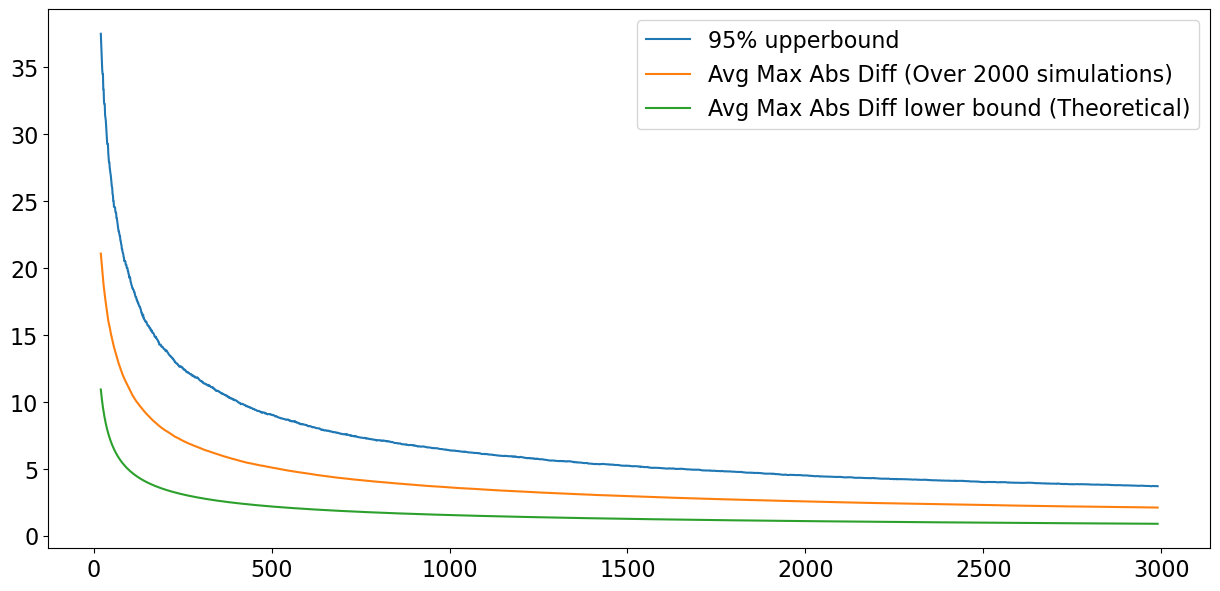

In [7]:
x_axis = list(range(len(avg_max_diff)))
theoretical_bound = [2*(3/(16*i))**0.5/(math.sqrt(math.pi)) /1*100 for i in range(10,len(avg_max_diff))]
# plt.scatter(x_axis,avg_diff, label = "Avg Diff")
plt.plot(x_axis[20:], max_diff_95[20:], label = "95% upperbound")
plt.plot(x_axis[20:], avg_max_diff[20:], label = "Avg Max Abs Diff (Over 2000 simulations)")
# plt.scatter(x_axis,win_rate_diff, label = "Avg Win-rate Diff  (dist>=3)")
plt.plot(x_axis[20:], theoretical_bound[10:], label = "Avg Max Abs Diff lower bound (Theoretical)")
# plt.suptitle('Round-count vs Win-Rate Diff')

plt.rcParams["figure.figsize"] = (15,8)
# plt.suptitle('Round-count vs Win-Rate Diff')
plt.legend()
plt.show()

72773 out of 98209 rounds filtered in, discarding 25.90 % games


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


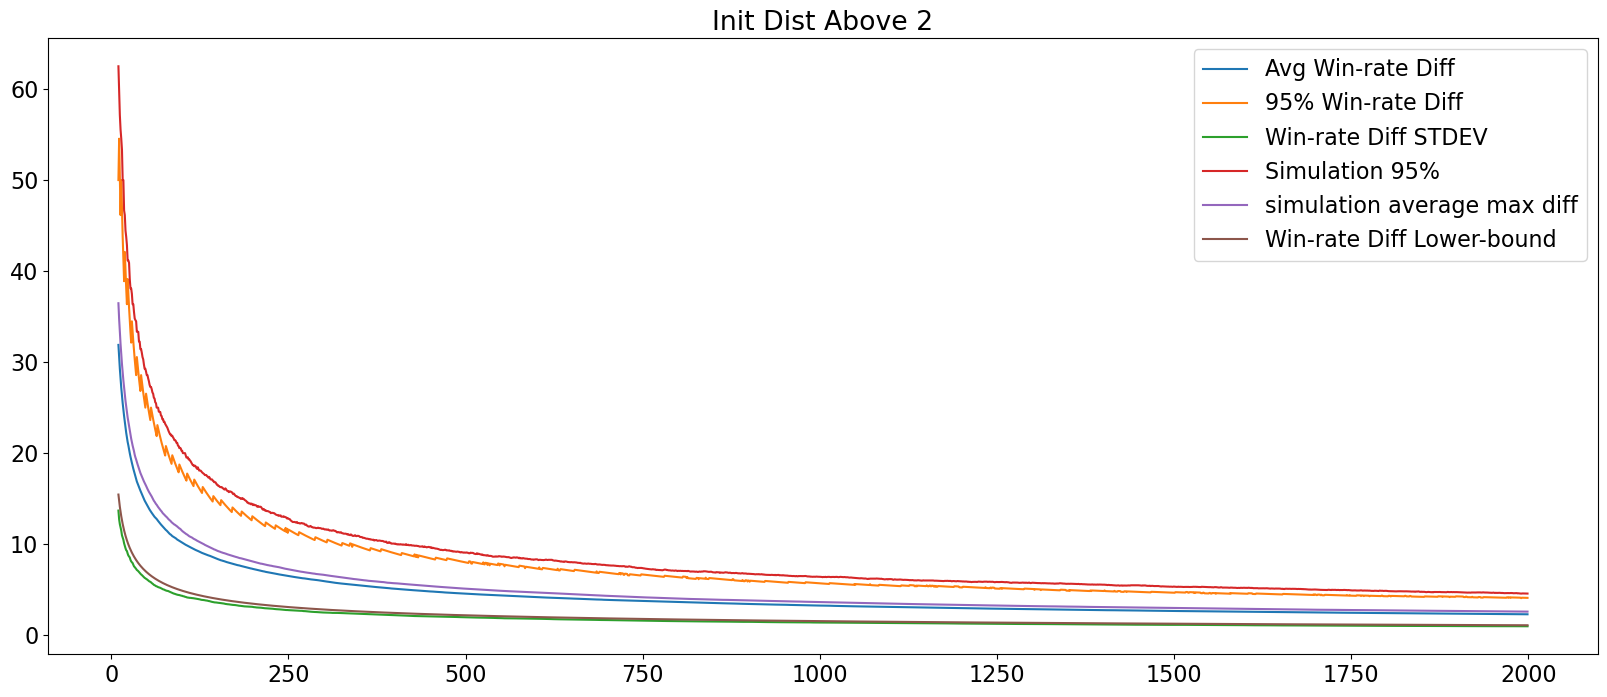

In [10]:
graph_raw_win_rate('..', 'dat_above_2.npy', "Init Dist Above 2", max_diff_95, avg_max_diff)

72773 out of 98209 rounds filtered in, discarding 25.90 % games


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


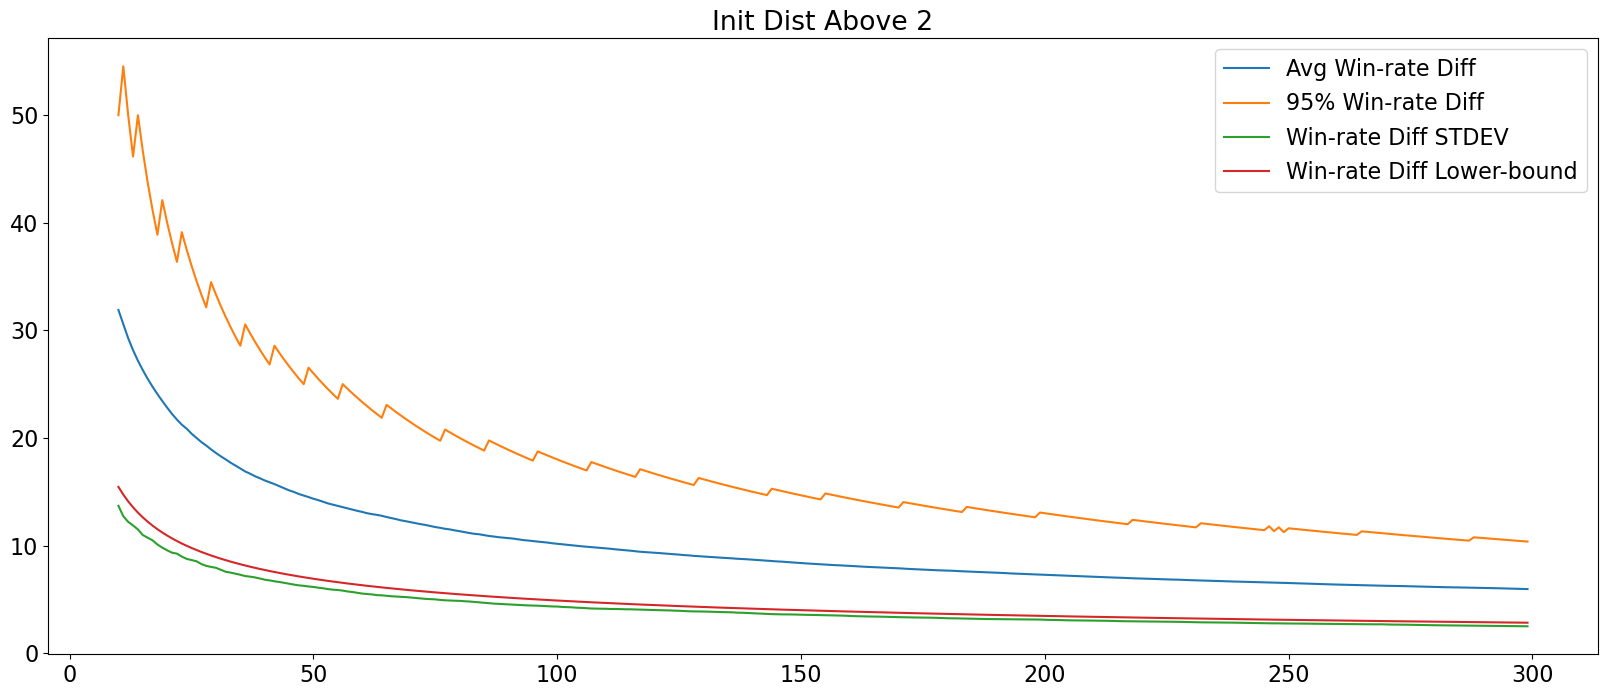

In [7]:
curve_above_2 = graph_raw_win_rate_short('..', 'dat_above_2.npy', "Init Dist Above 2")

53273 out of 98209 rounds filtered in, discarding 45.76 % games


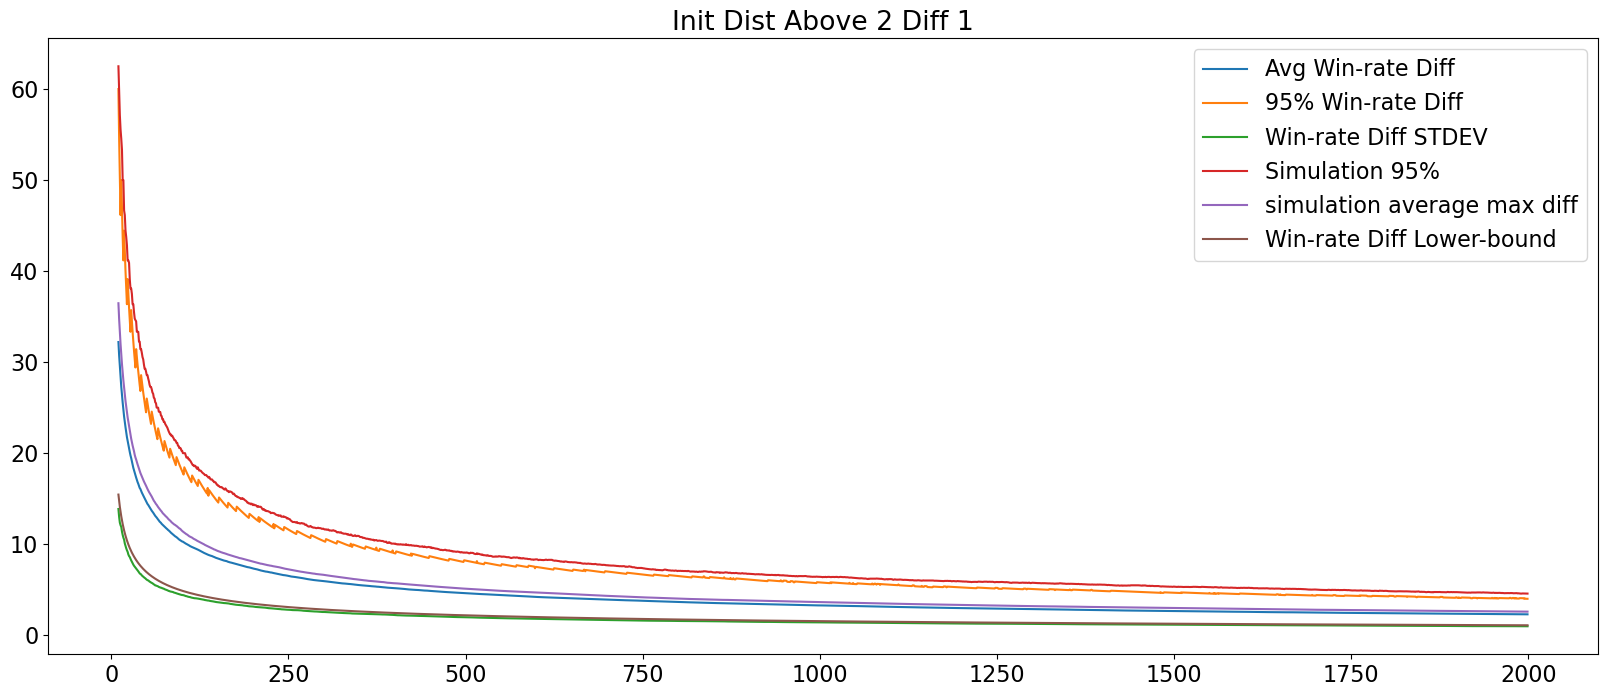

In [11]:
graph_raw_win_rate('..', 'dat_above_2_diff_1.npy', "Init Dist Above 2 Diff 1", max_diff_95, avg_max_diff)

53273 out of 98209 rounds filtered in, discarding 45.76 % games


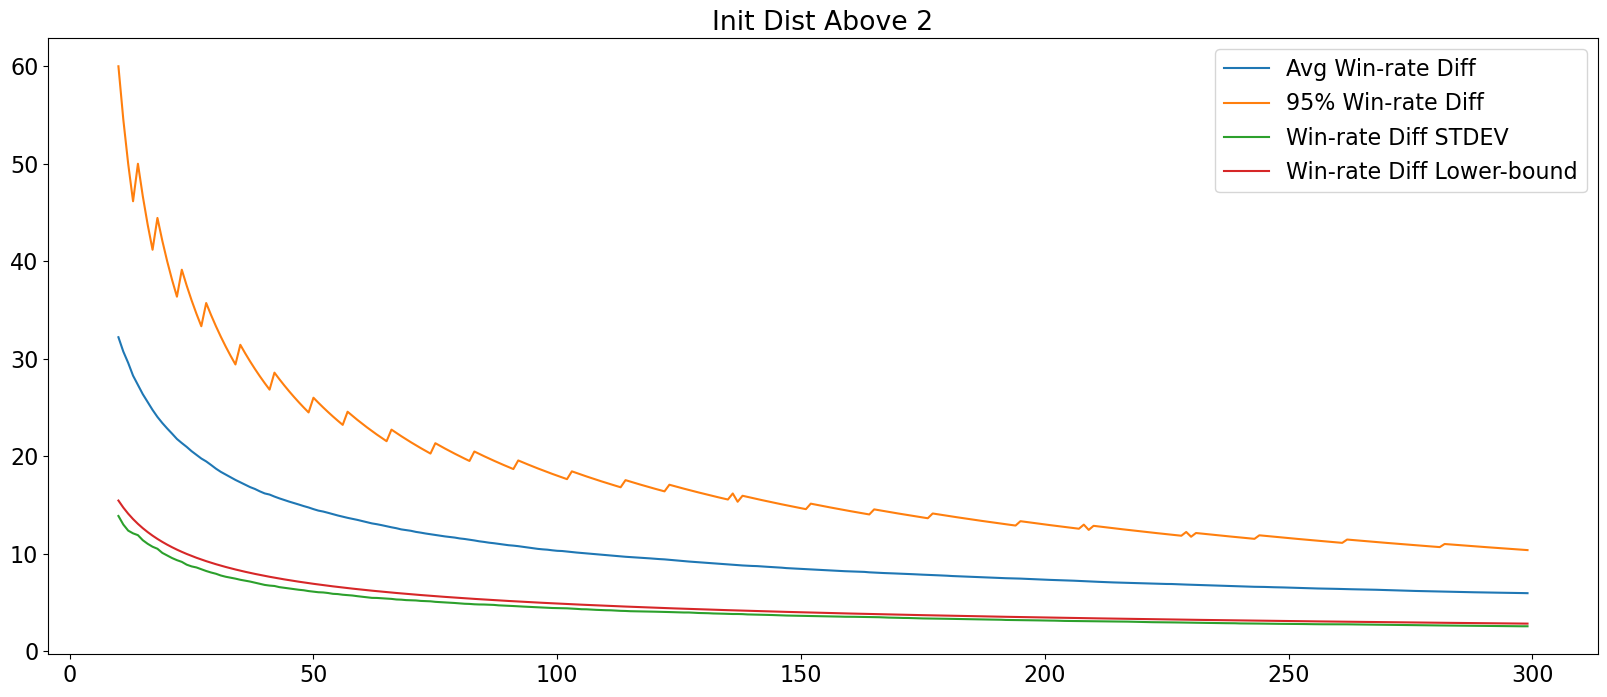

In [9]:
curve_above_2_diff_1 = graph_raw_win_rate_short('..', 'dat_above_2_diff_1.npy', "Init Dist Above 2")

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


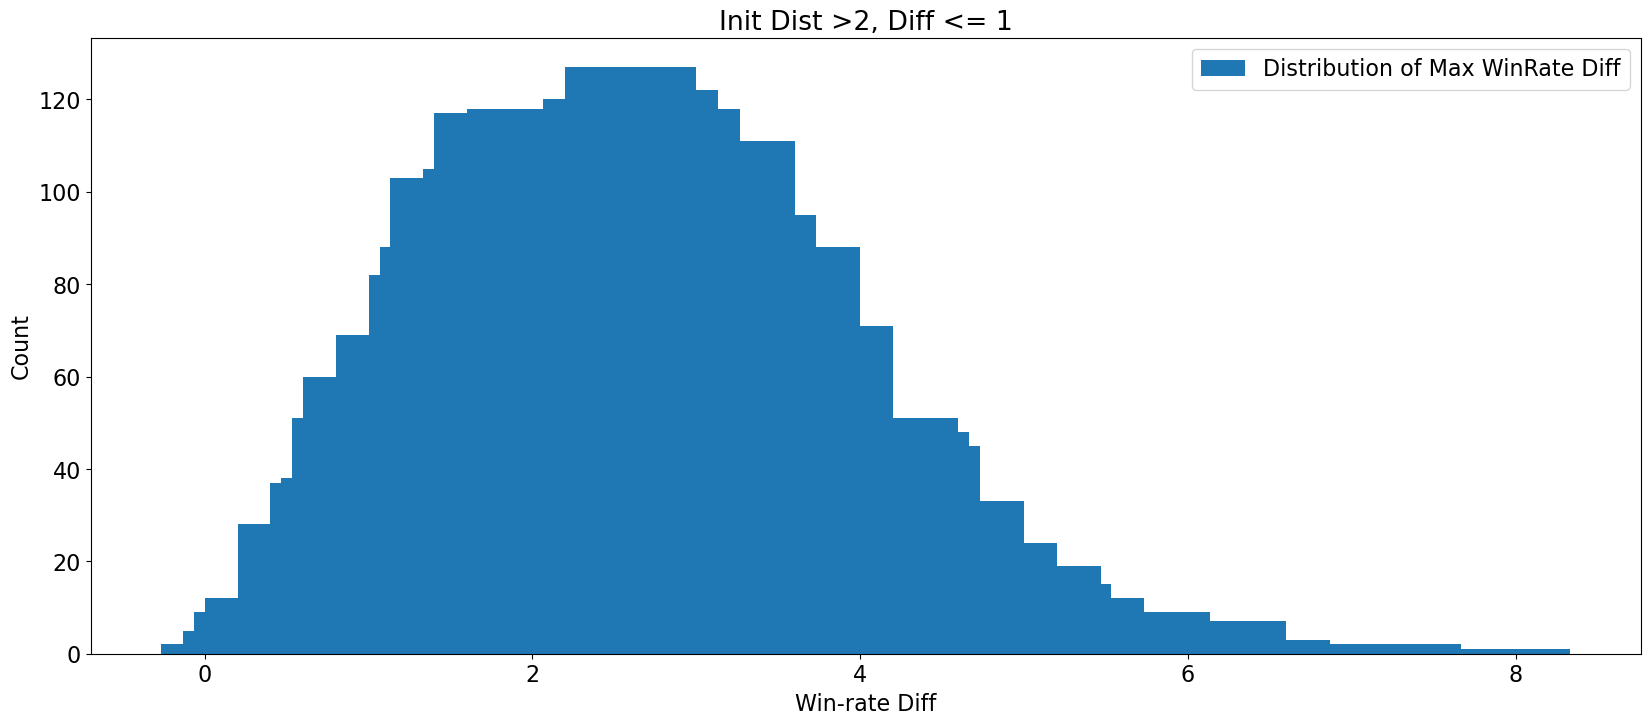

In [7]:
wr_diff_distri=graph_win_rate_distri('..', 'dat_above_2_diff_1.npy', "Init Dist >2, Diff <= 1")

53273 out of 98209 rounds filtered in, discarding 45.76 % games


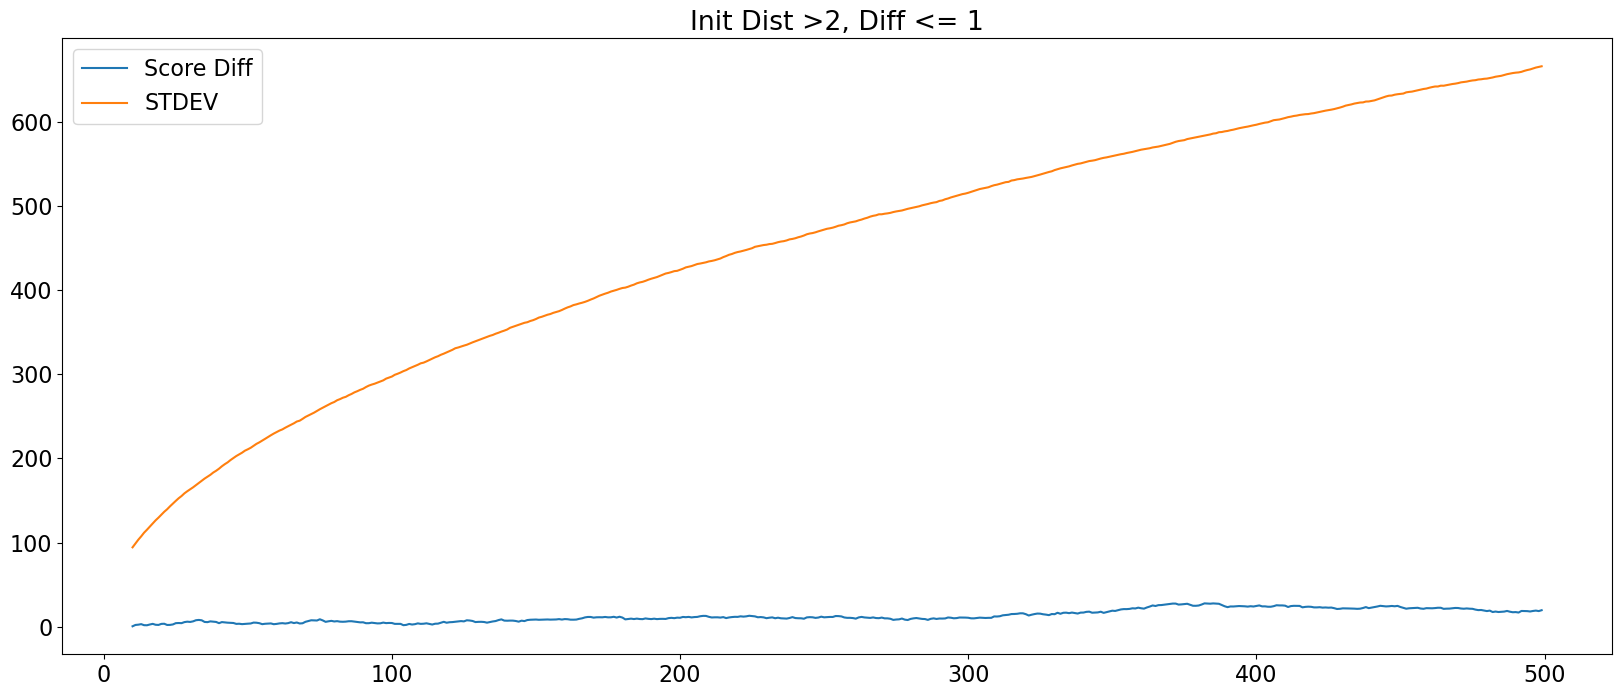

In [9]:
graph_diffs('..', 'dat_above_2_diff_1.npy', "Init Dist >2, Diff <= 1")

32107 out of 32768 rounds filtered in, discarding 2.02 % games


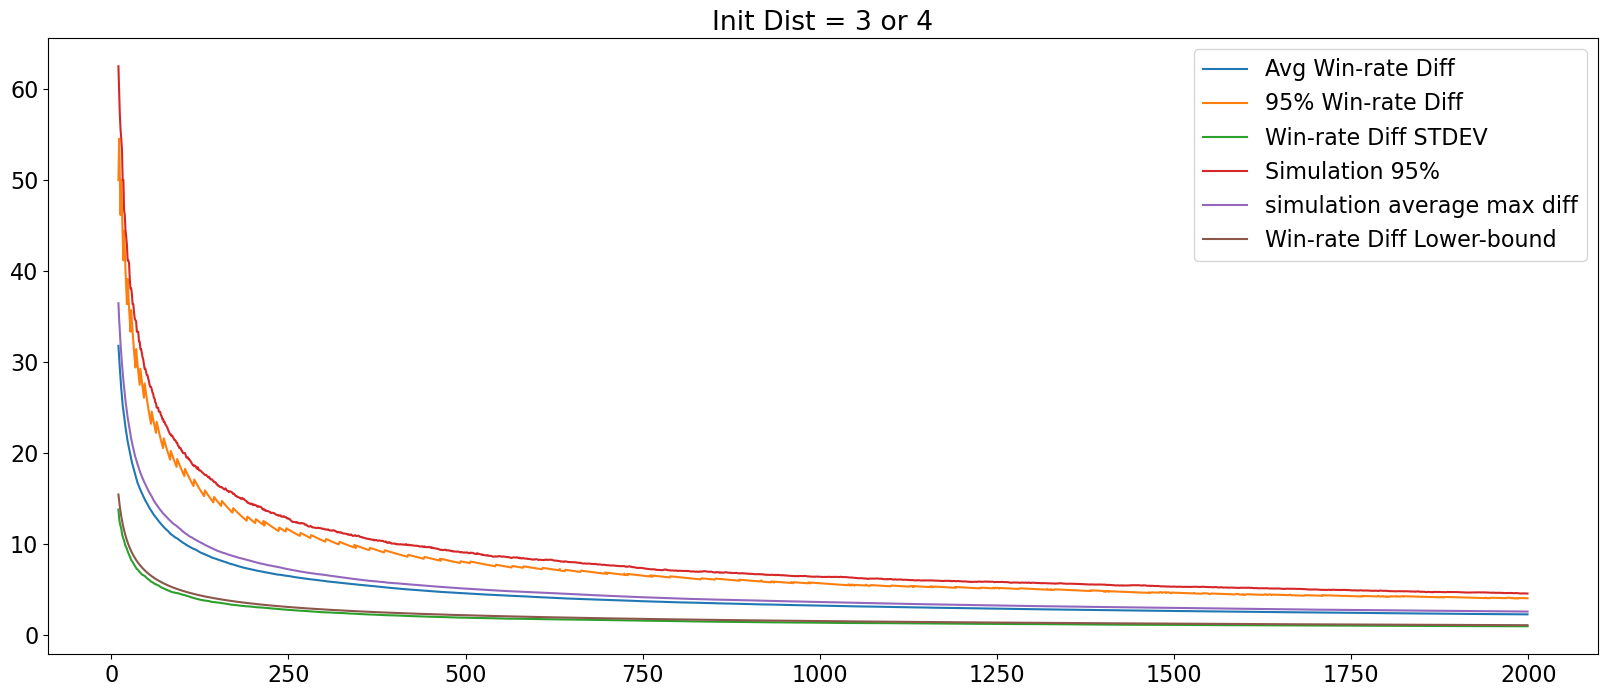

In [12]:
graph_raw_win_rate('..', 'dat_strict_3_or_4.npy', "Init Dist = 3 or 4", max_diff_95, avg_max_diff)

32107 out of 32768 rounds filtered in, discarding 2.02 % games


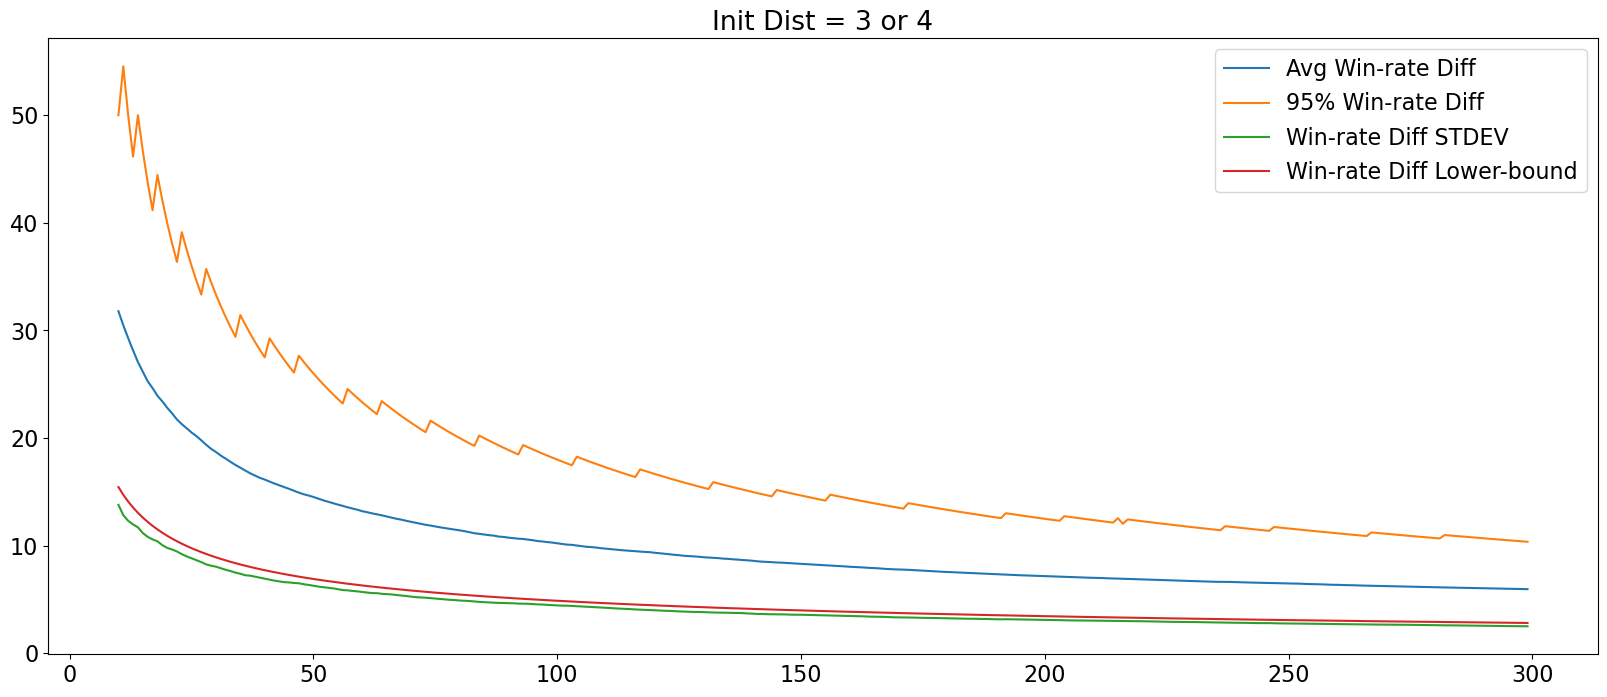

In [13]:
curve_strict_3_or_4=graph_raw_win_rate_short('..', 'dat_strict_3_or_4.npy', "Init Dist = 3 or 4")

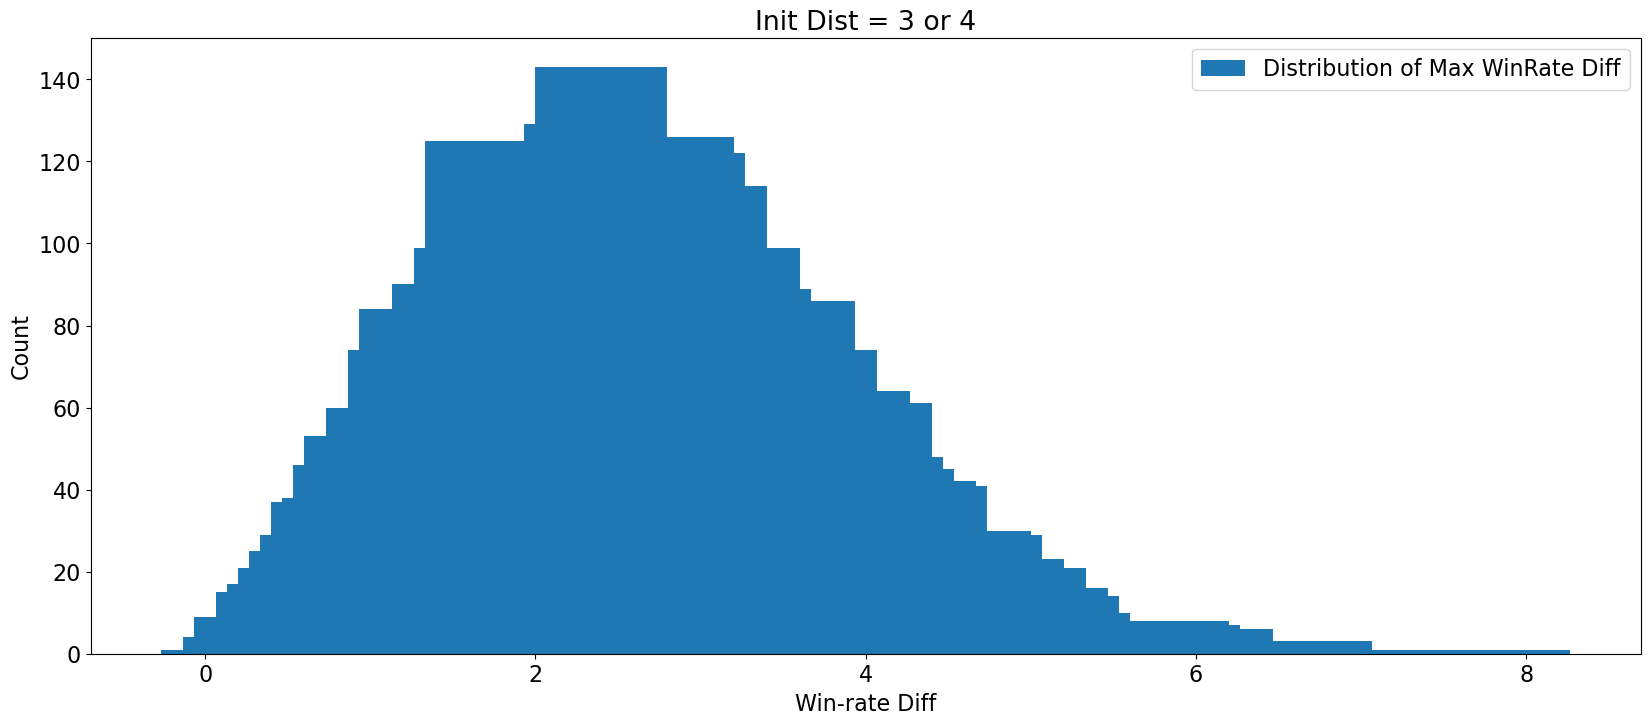

In [8]:
distri_3_4 = graph_win_rate_distri('..', 'dat_strict_3_or_4.npy', "Init Dist = 3 or 4")

32107 out of 32768 rounds filtered in, discarding 2.02 % games


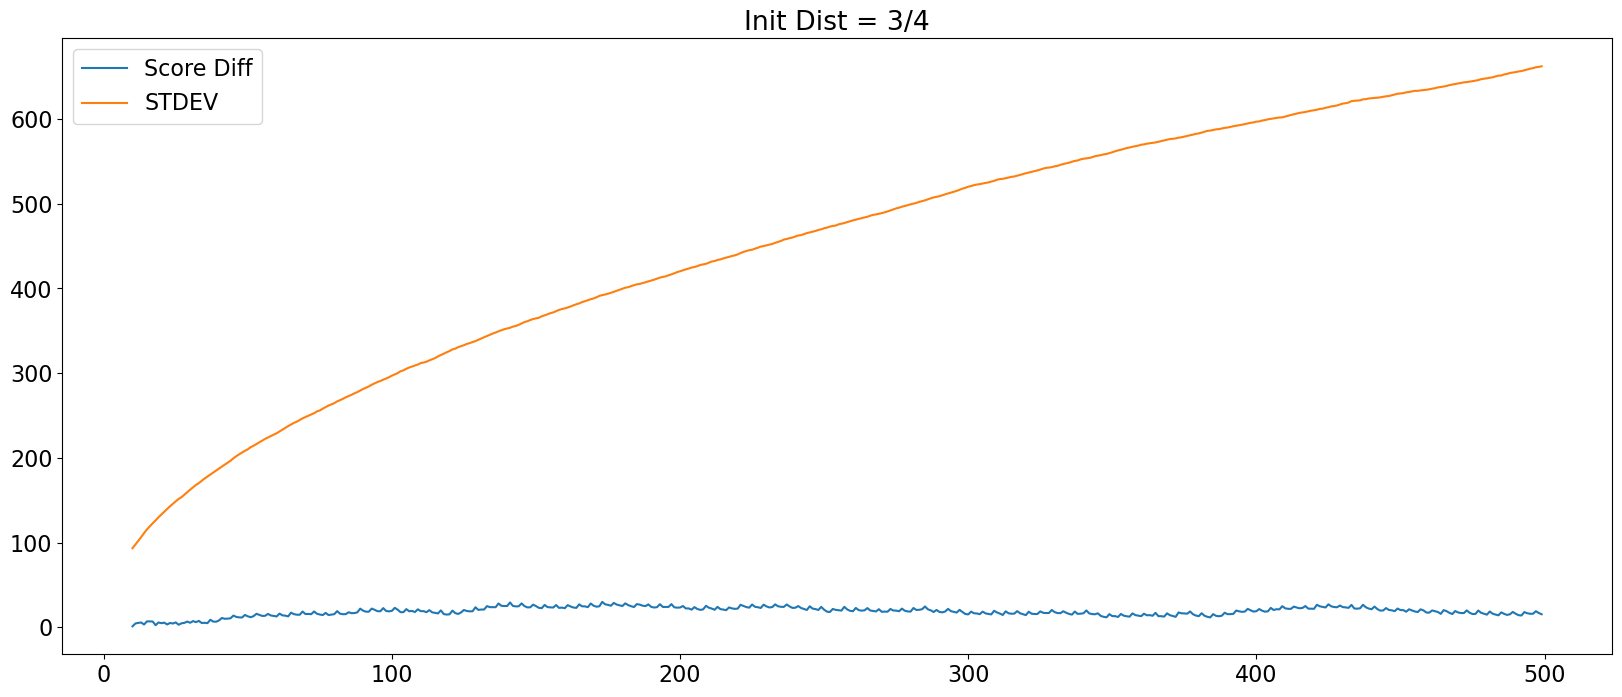

In [10]:
graph_diffs('..', 'dat_strict_3_or_4.npy', "Init Dist = 3/4")

22369 out of 32768 rounds filtered in, discarding 31.74 % games


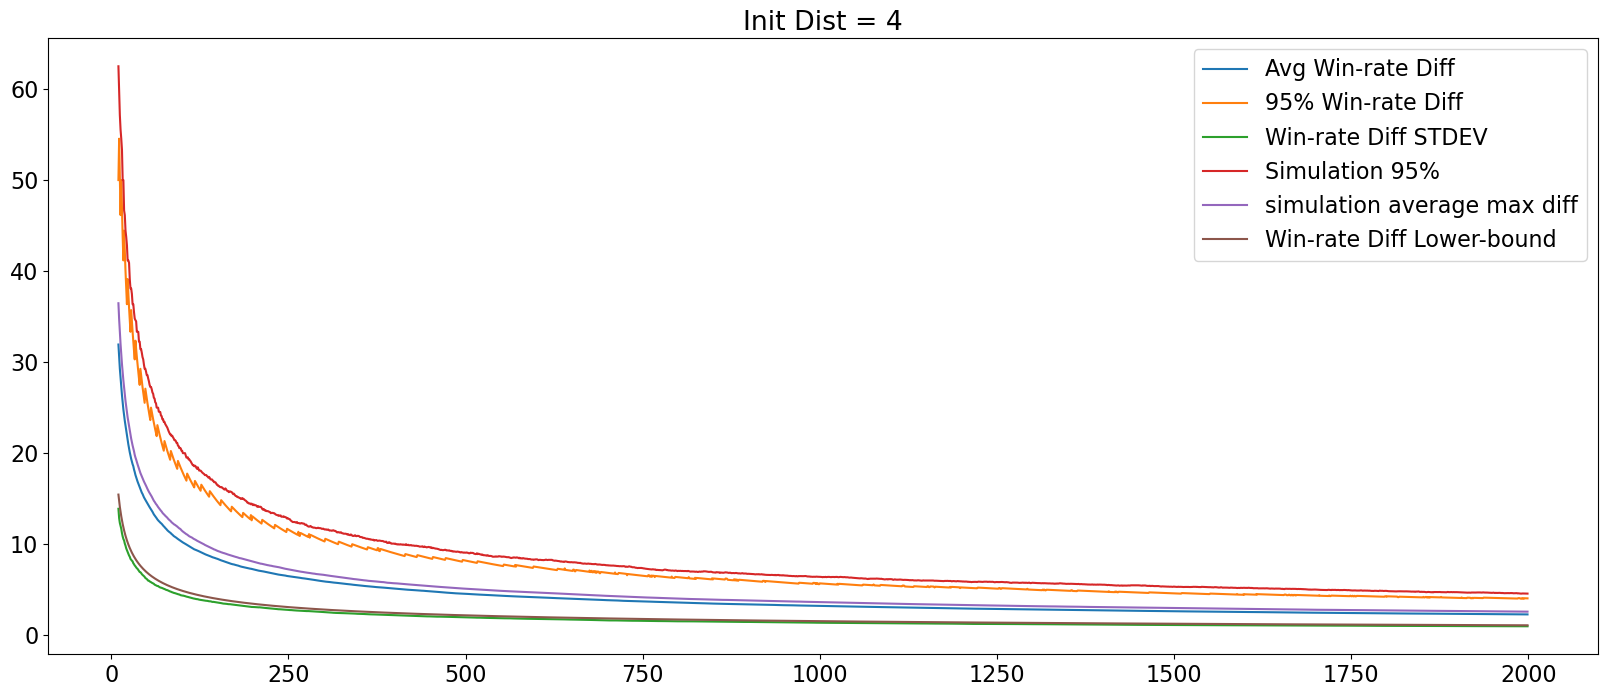

In [13]:
graph_raw_win_rate('..', 'dat_strict_4.npy', "Init Dist = 4", max_diff_95, avg_max_diff)

22369 out of 32768 rounds filtered in, discarding 31.74 % games


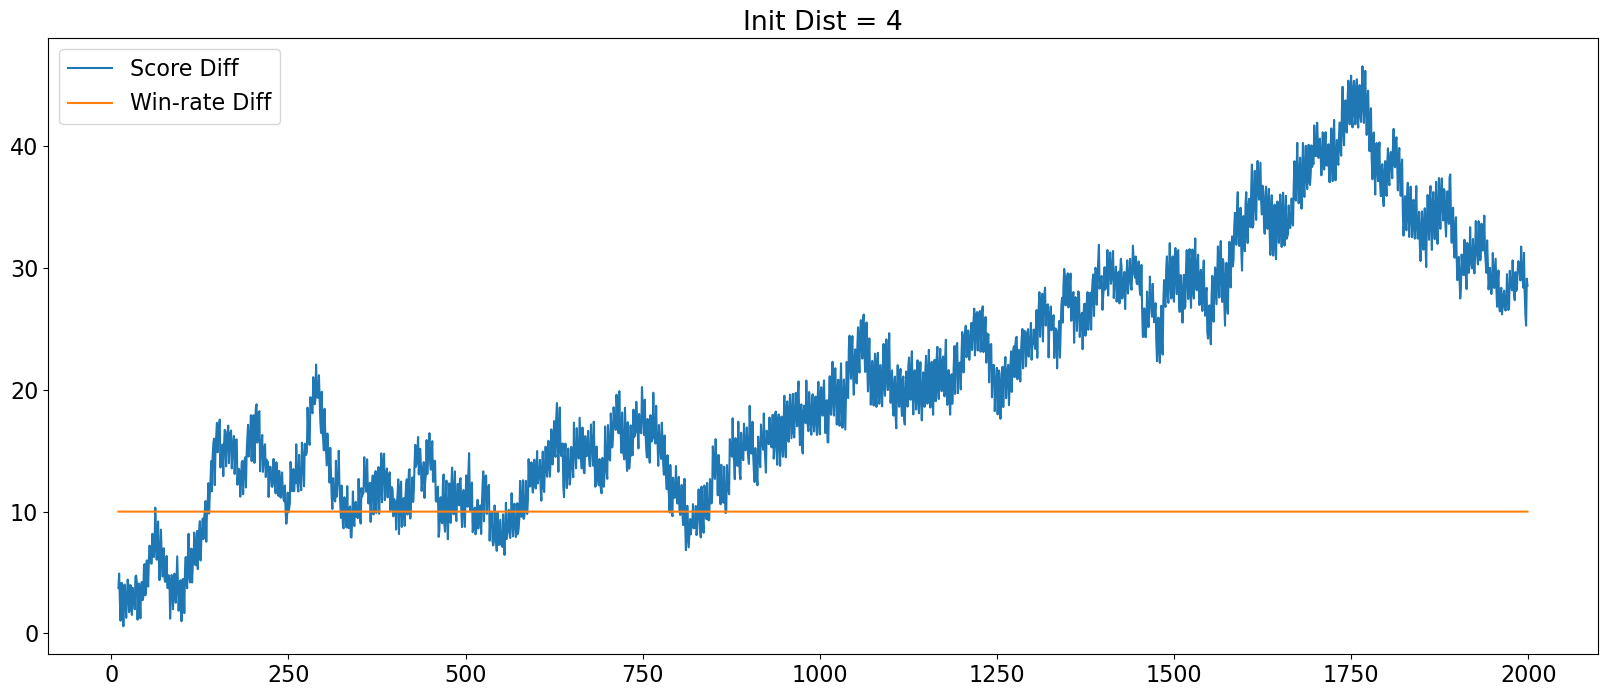

In [26]:
graph_diffs('..', 'dat_strict_4.npy', "Init Dist = 4")

98209 out of 98209 rounds filtered in, discarding 0.00 % games


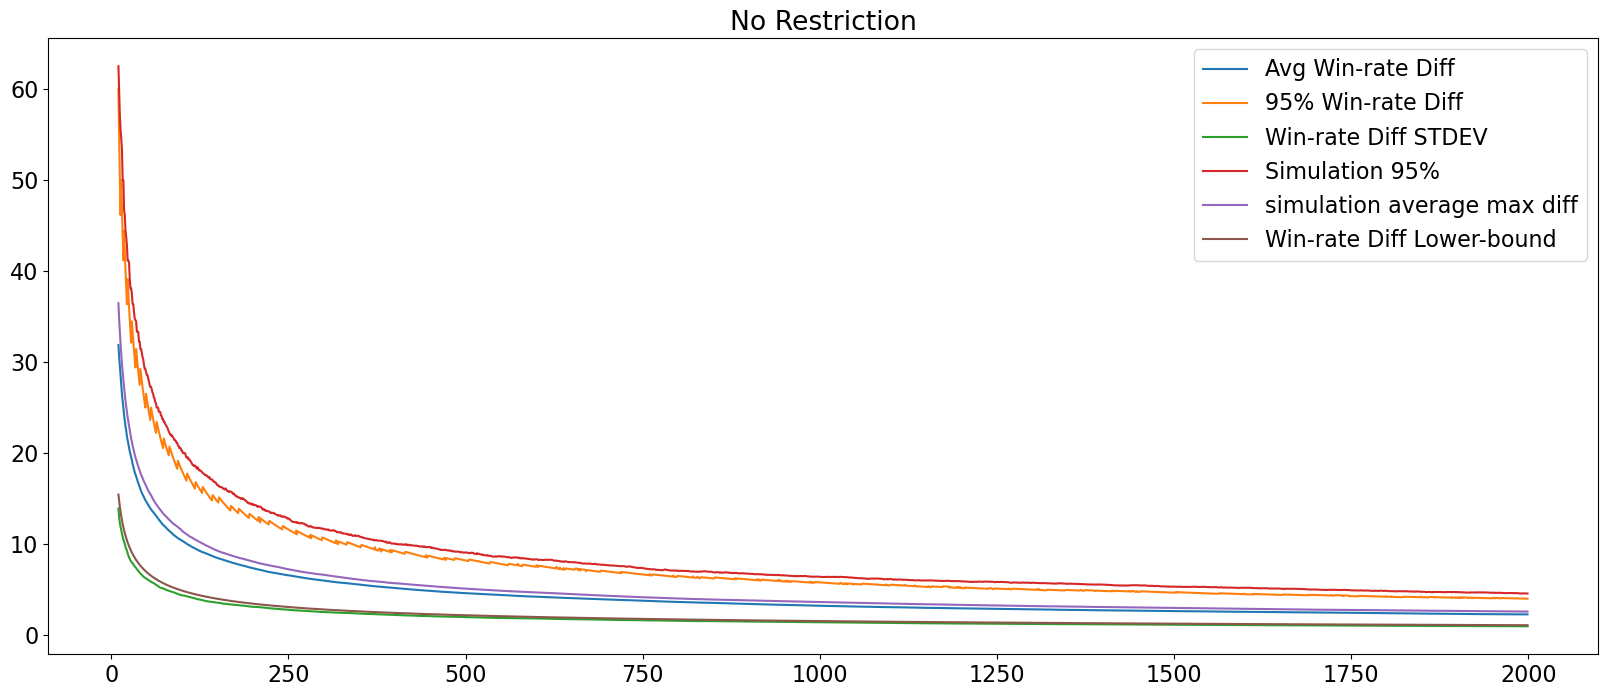

In [14]:
graph_raw_win_rate('..', 'dat_no_restriction.npy', "No Restriction", max_diff_95, avg_max_diff)

98209 out of 98209 rounds filtered in, discarding 0.00 % games


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


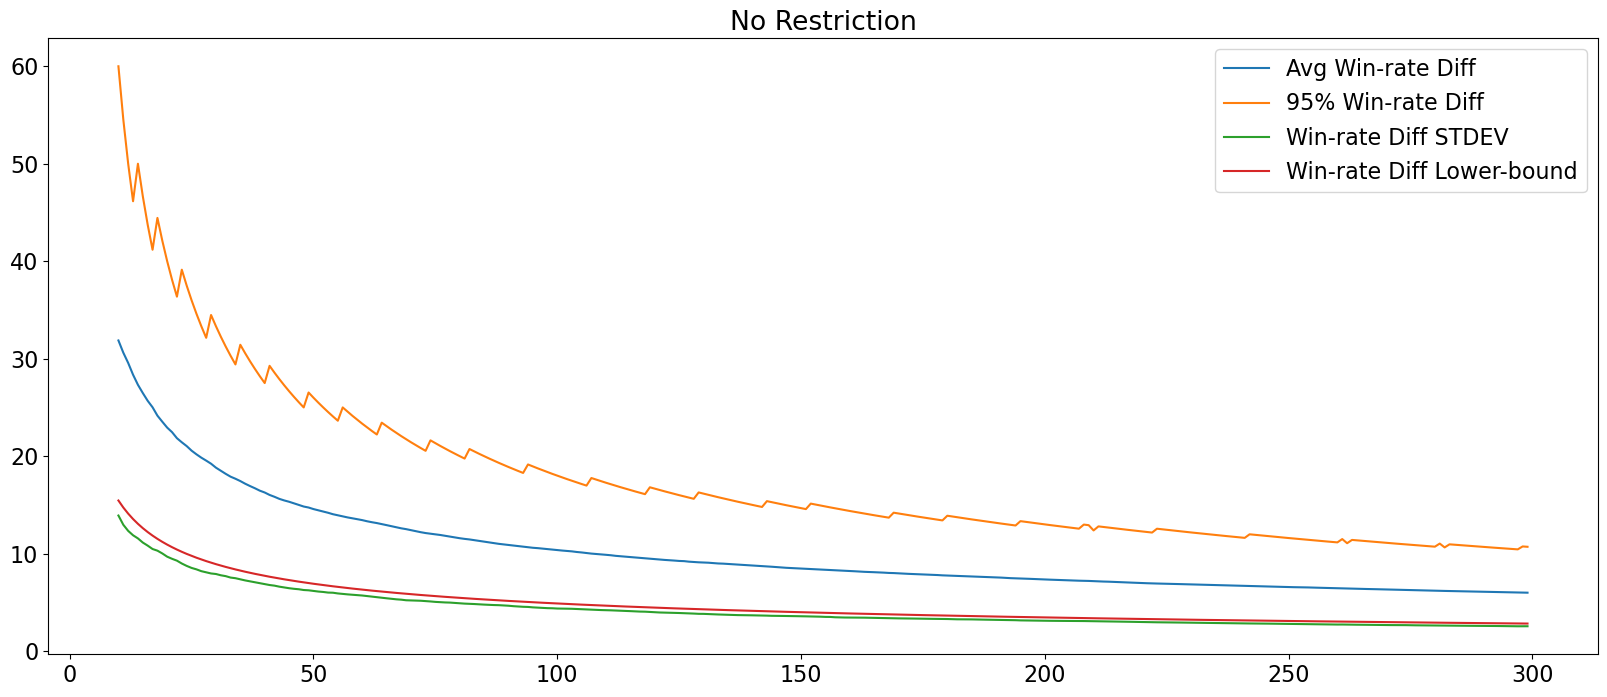

In [7]:
curve_no_res = graph_raw_win_rate_short('..', 'dat_no_restriction.npy', "No Restriction")

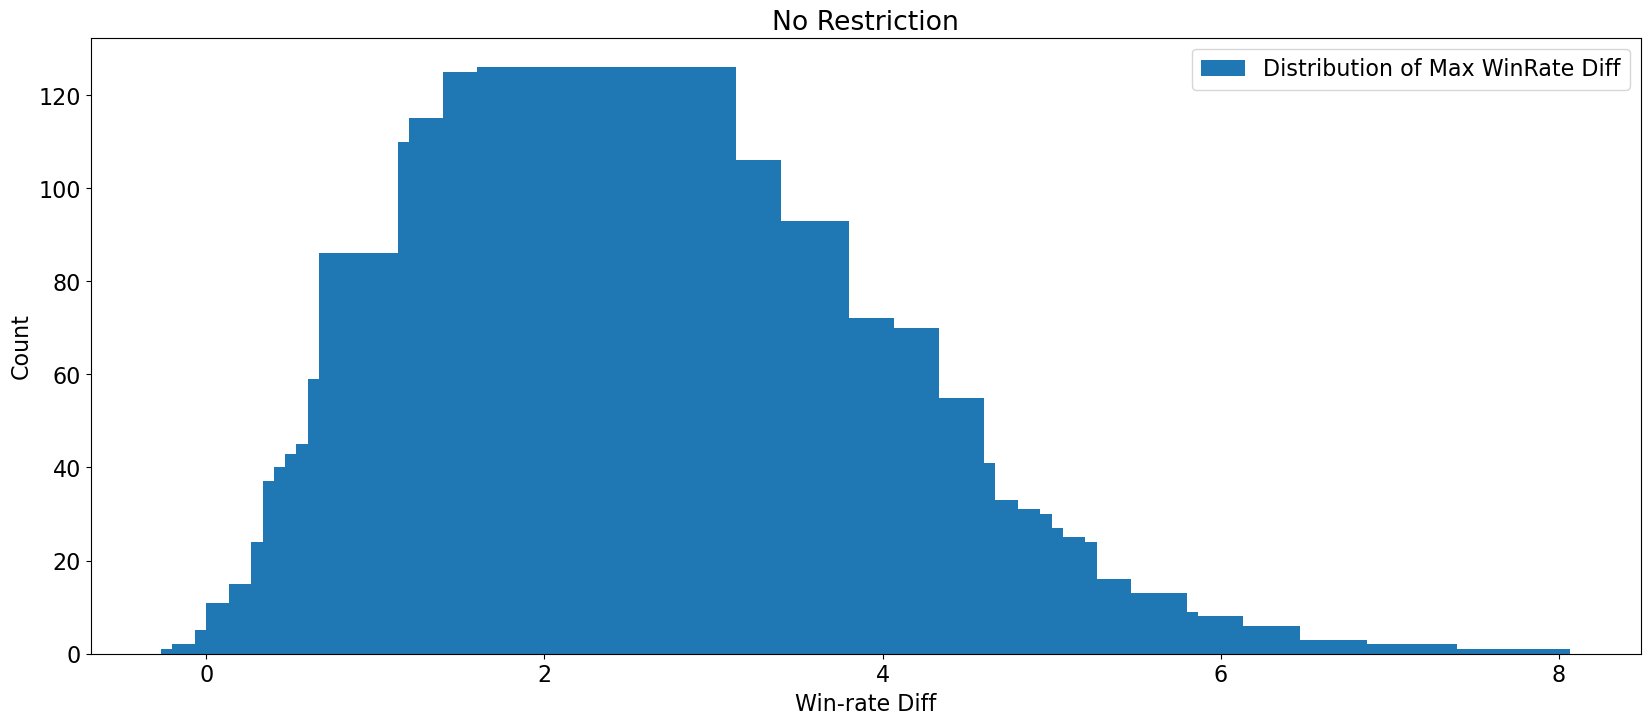

In [8]:
distri_no_res =graph_win_rate_distri('..', 'dat_no_restriction.npy', "No Restriction")

In [10]:
distri_no_res_formated = defaultdict(default_value)
distri_3_4_formated = defaultdict(default_value)
for i in range(12*2):
    val = i/2
    distri_3_4_formated[val]=0
    distri_no_res_formated[val]=0
    for key in wr_diff_distri:
        if key>val and key<val+0.5:
            distri_3_4_formated[val]+=wr_diff_distri[key]
    for key in distri_no_res:
        if key>val and key<val+0.5:
            distri_no_res_formated[val]+=distri_no_res[key]
        

In [ ]:
wr_diff_distri

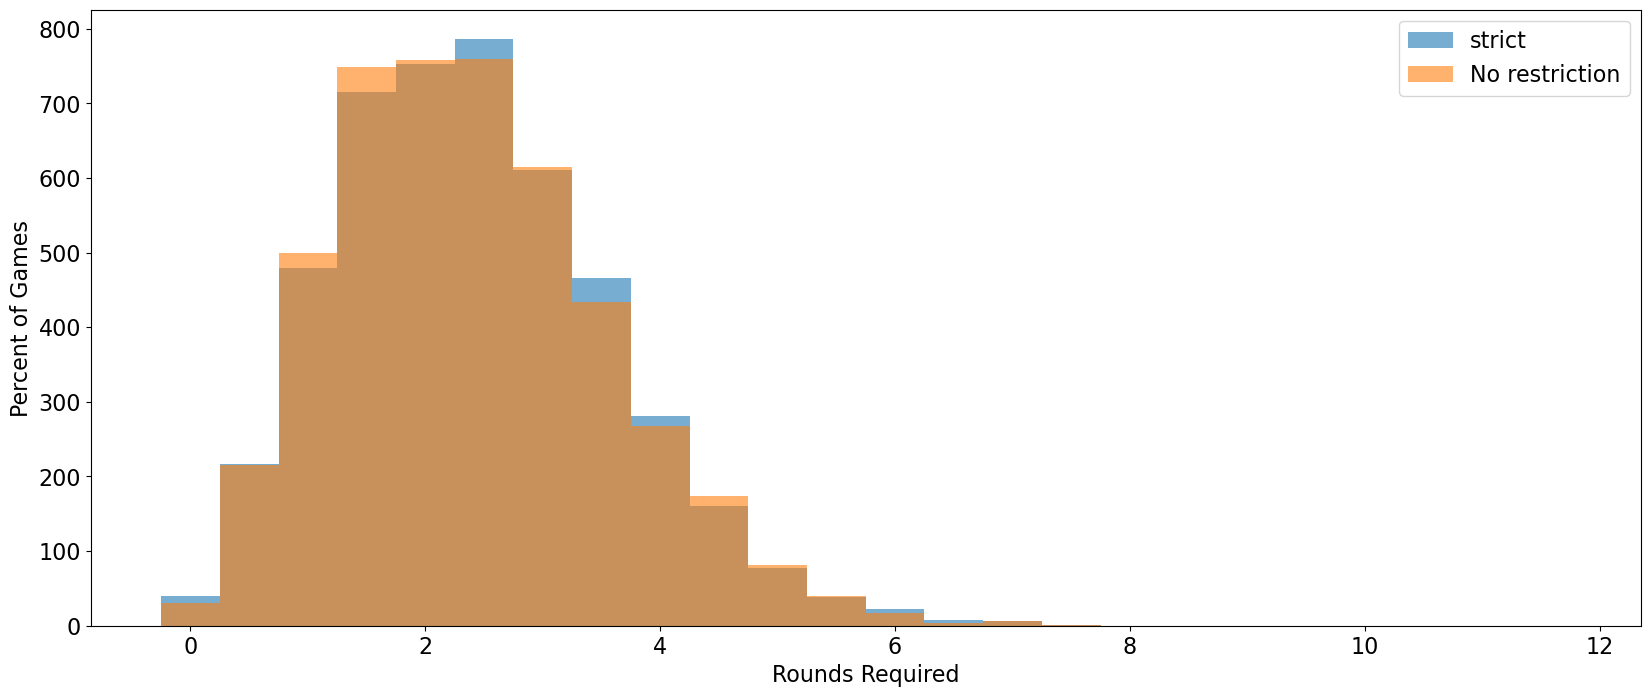

In [11]:
fig, ax = plt.subplots()
bars = ax.bar(list(distri_3_4_formated.keys()), list(distri_3_4_formated.values()), label = "strict", alpha=0.6, width=0.5)
bar = ax.bar(list(distri_3_4_formated.keys()), list(distri_no_res_formated.values()), label = "No restriction", alpha=0.6, width=0.5)
# plt.bar(dists, values, tick_label=dists, label=values)
# print(winner_relative_init_pos_polar)
plt.xlabel("Rounds Required")
plt.ylabel("Percent of Games")
plt.legend()
plt.show()

98209 out of 98209 rounds filtered in, discarding 0.00 % games


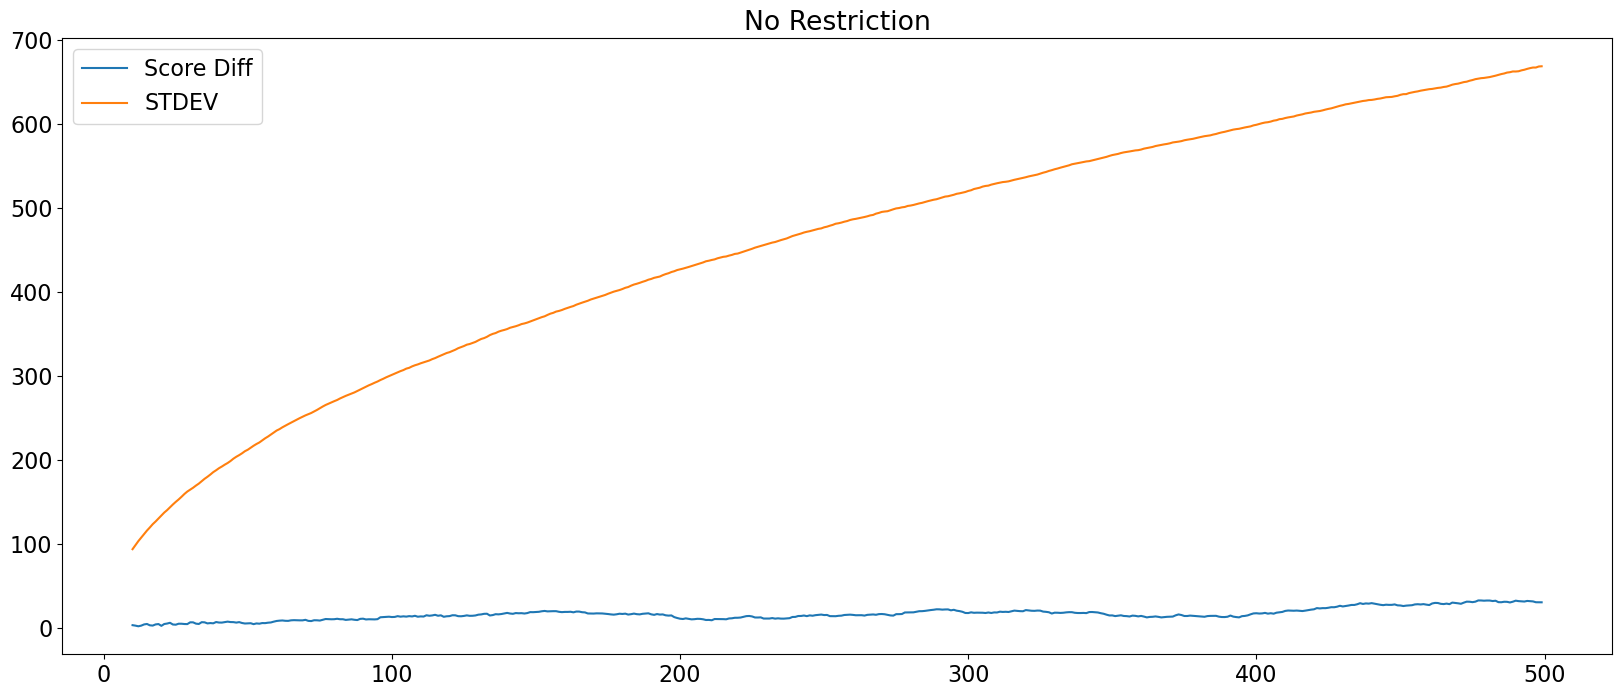

In [11]:
graph_diffs('..', 'dat_no_restriction.npy', "No Restriction")

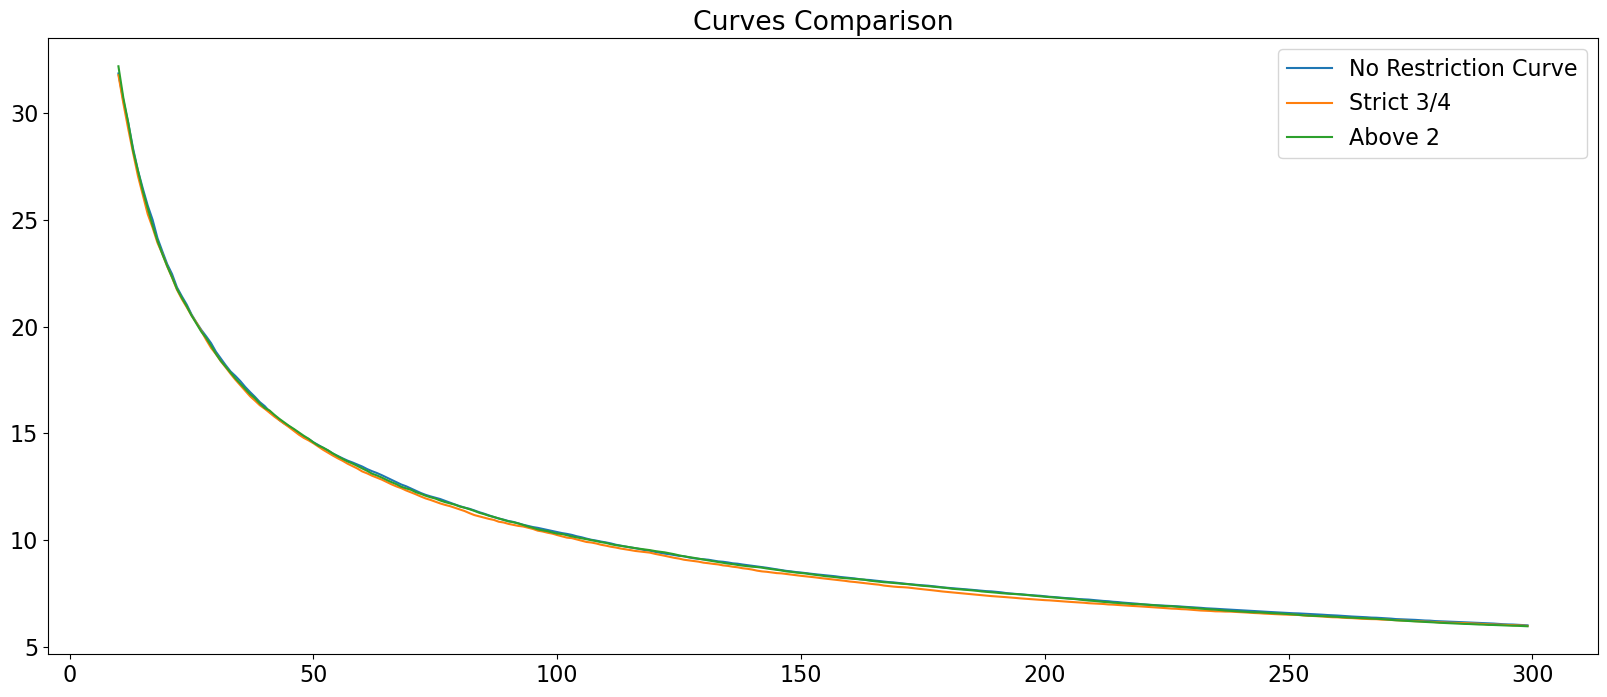

In [15]:
plt.rcParams["figure.figsize"] = (20,8)
plt.rcParams['font.sans-serif']=['SimHei']
x_axis = list(range(10,300))
# plt.scatter(x_axis,win_rate_diff_strict3, label = "Avg Win-rate Diff")
plt.plot(x_axis, curve_no_res, label = "No Restriction Curve")
plt.plot(x_axis, curve_strict_3_or_4, label = "Strict 3/4")
plt.plot(x_axis, curve_above_2_diff_1, label = "Above 2 Diff 1")
# plt.suptitle('Round-count vs Win-Rate Diff')
plt.legend()
plt.title("Curves Comparison")   # 柱状图标题
plt.show()